In [43]:
import pandas as pd
import numpy as np
%matplotlib inline
from IPython import display
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing

import os
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
#from IPython.display import HTML
#from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [92]:
ls

Untitled.ipynb                    uber-raw-data-jul14.csv*
taxi-zone-lookup.csv*             uber-raw-data-jun14.csv*
uber-raw-data-apr14.csv*          uber-raw-data-may14.csv*
uber-raw-data-aug14.csv*          uber-raw-data-sep14.csv*
uber-raw-data-janjune-15.csv.zip*


In [86]:
# 原始数据按月存放于多个文件，此处采用循环读取数据
months = ['apr','may','jun','jul','aug','sep']
pieces = []
columns = ['dt','lat','lon','base']
for month in months:
    path = 'uber-raw-data-%s14.csv' % month
    frame = pd.read_csv(path,names=columns,header=None,skiprows=1)
    frame['month'] = month
    pieces.append(frame)

In [124]:
df = pd.concat(pieces,ignore_index=True)

In [121]:
print(df.shape)
df.head()

(4534327, 5)


,dt,lat,lon,base,month
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,apr
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,apr
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,apr
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,apr
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,apr


In [117]:
df.describe()

,lat,lon
count,4.534327e+06,4.534327e+06
mean,4.073926e+01,-7.397302e+01
std,3.994991e-02,5.726670e-02
min,3.965690e+01,-7.492900e+01
25%,4.072110e+01,-7.399650e+01
50%,4.074220e+01,-7.398340e+01
75%,4.076100e+01,-7.396530e+01
max,4.211660e+01,-7.206660e+01


In [113]:
agg = df.groupby('month').agg({'base':'count'})
agg

,base
month,
apr,564516
aug,829275
jul,796121
jun,663844
may,652435
sep,1028136


In [131]:
df = df.query('lat>=40.5 & lat<=41.1')
df = df.query('lon<=-73.4 & lon>=-74.2')

In [135]:
clus = df[['lat','lon']]

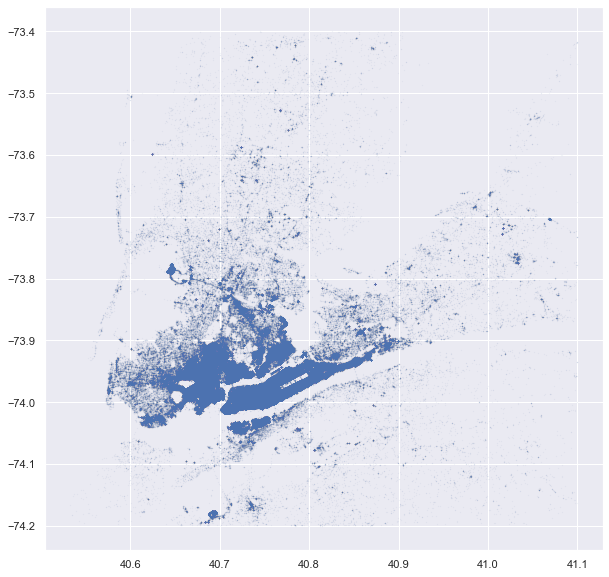

In [136]:
plt.figure(figsize=(10,10))
plt.plot(clus['lat'],clus['lon'],'.',alpha=0.3,markersize=.15)
plt.show()

In [137]:
kmeans = KMeans(n_clusters=20, max_iter = 300, random_state=12345)
kmeans.fit(clus)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [138]:
clus['label'] = kmeans.labels_

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [140]:
clus.label.value_counts()

7     1076512
16     695594
0      642632
12     527092
2      468821
4      247848
13     189635
9      117092
19     115045
1      113497
10      92026
5       63070
15      48183
3       37134
17      34066
18      27356
8       11399
6        7966
14       5041
11       3985
Name: label, dtype: int64

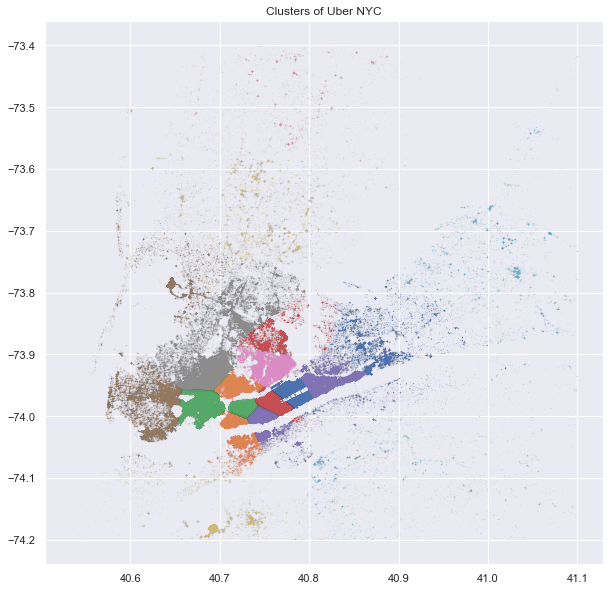

In [222]:
plt.figure(figsize=(10,10))
for label in clus.label.unique():
    plt.plot(clus.lat[clus.label==label],clus.lon[clus.label==label],'.',alpha=0.4,markersize=0.15)
    
plt.title('Clusters of Uber NYC')
plt.show()

In [145]:
clusters = pd.DataFrame()
clusters['lat'] = kmeans.cluster_centers_[:,0]
clusters['lon'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [148]:
import folium

In [150]:
centroid = clocation.values.tolist()
map = folium.Map(location=[40.79658011772687, -73.87341741832425],zoom_start=25)
for i,j in clusters.iterrows():
    folium.Marker(location=[j.lat, j.lon],popup=str(j.label)).add_to(map)
    
map

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


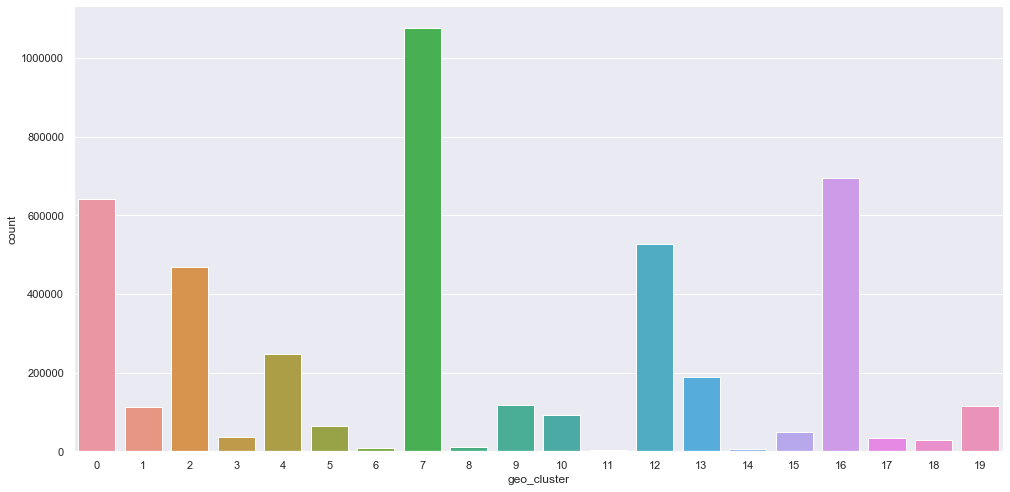

In [162]:
sns.factorplot(data=df,x='geo_cluster',kind='count',size=7,aspect=2)

In [170]:
df['dt'] = pd.to_datetime(df['dt'])
df['date'] = df.dt.dt.date

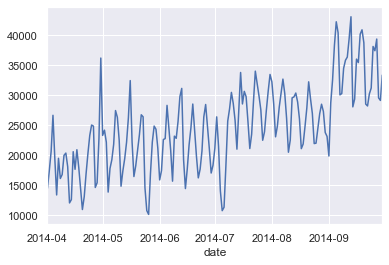

In [171]:
df.groupby('date')['dt'].count().plot()

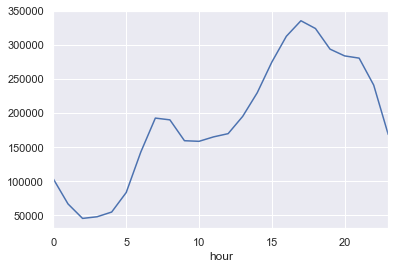

In [172]:
df['hour'] = df.dt.dt.hour
df.groupby('hour')['dt'].count().plot()

In [174]:
temp = df.groupby(['hour','geo_cluster'])['base'].count()
temp.reset_index().sort_values(by='base',ascending=False).head()

,hour,geo_cluster,base
347,17,7,101179
327,16,7,94202
367,18,7,94014
387,19,7,82314
407,20,7,76623


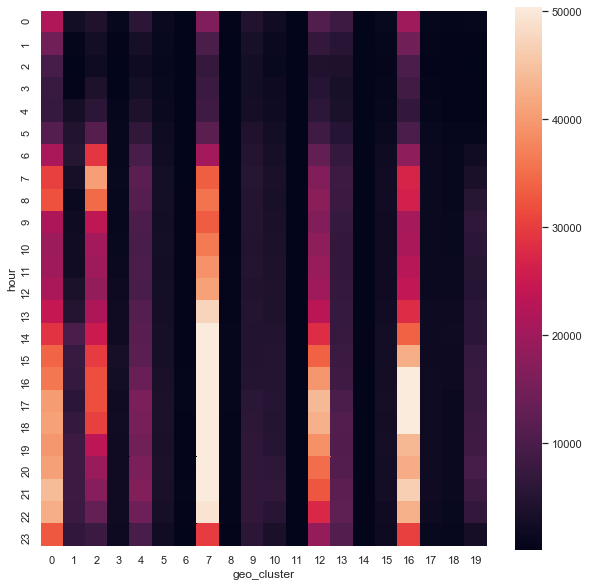

In [175]:
plt.figure(figsize=(10,10))
sns.heatmap(temp.unstack().fillna(0),square=True,robust=True)

In [201]:
def plot_heatmap_month(month):
    df_month = df[df.month==month]
    
    temp = df_month.groupby(['hour','geo_cluster'])['base'].count()
    temp.fillna(0)
    
    plt.figure(figsize=(10,10))
    sns.heatmap(temp.unstack().fillna(0),square=True)
    #plt.title('Heatmap of rides by cluster & time at %s' % month)

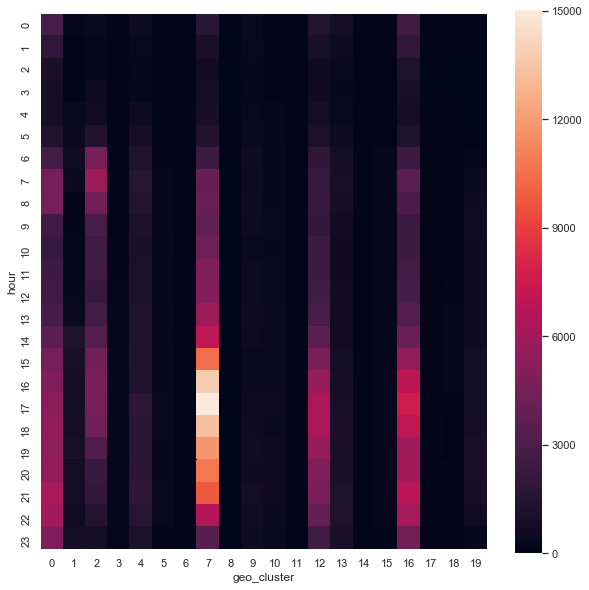

In [202]:
plot_heatmap_month('apr')

In [206]:
interact(plot_heatmap_month,month=widgets.Select(options=['apr', 'may', 'jun', 'jul', 'aug', 'sep'],
                                                         value='apr',
                                                         description='month',
                                                         disabled=False))

interactive(children=(Select(description='month', options=('apr', 'may', 'jun', 'jul', 'aug', 'sep'), value='a…

<function __main__.plot_heatmap_month(month)>